# Тестовое задание для компании "Контур"

Вам предоставлены два файла:

- `user_info.json` &mdash; содержит информацию о пользователях внутри некоторого
    вымышленного периметра. Структура:
    - `GUID` &mdash; идентификатор пользователя
    - `LastName`, `FirstName`, `MiddleName` &mdash; составляющие полного имени
        пользователя
- `logins.csv` &mdash; содержит информацию о входах пользователей в систему за
    некоторый промежуток времени. Структура:
    - `Timestamp` &mdash; время логина пользователя
    - `GUID` &mdash; идентификатор пользователя в локальной системе учёта
        пользователей внутри периметра
    - `OuterIP` &mdash; IP-адрес, с которого пользователь подключается
        посредством VPN к внутренней сети
    - `InnerIP` &mdash; внутренний IP-адрес пользователя
    - `OpenVPNServer` &mdash; адрес сервера OpenVPN, через который пользователь
        подключается ко внутренней сети
    - `NgToken` &mdash; токен, который проставляет сервер NginX,
        идентифицирующий рабочее место пользователя (конкретный браузер)

        
Задания

1. Опишите данные. Какие пользователи логинятся чаще всего? Есть ли сезонные
   составляющие? Как выглядят распределения пользователей по количеству
   уникальных внешних IP-адресов или рабочих мест?
2. Попытайтесь найти аномальные виды поведения:
    - Есть ли пользователи, которые подключаются к чужим компьютерам?
    - Есть ли пользователи, которые не подключались несколько дней подряд?
3. Определите полные имена этих аномальных пользователей.
4. Напишите веб-приложение, с единственным методом API, которое принимало бы
   запрос в формате, указанном ниже, и возвращало бы какой-то сигнал, если в
   запросе присутствовал новый IP-адрес или NgToken для указанного пользователя.

Начнём с импорта необходимых библиотек

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
data_table = pd.read_csv('logins.csv',parse_dates=['Timestamp'])
data_table.sample(5)

,Unnamed: 0,Timestamp,GUID,OuterIP,NgToken,OpenVPNServer,InnerIP
31041,31041,2024-03-31 06:09:45,17b2afec-4c32-46ea-baaa-308c4ef427d6,153.137.93.49,CD22CCBCFC20A4D5FBF4,10.0.0.3,25.24.157.95
45020,45020,2024-04-14 17:28:32,2f2df771-94b8-4b00-873b-89823681dafc,154.49.133.7,EFB665EAF45CE2DCD84A,10.0.0.2,25.24.50.67
56199,56199,2024-04-26 12:49:01,171a2ffd-4714-478b-bb4d-df481f9d1b42,197.128.95.21,632DEBA5E2481F7D9AB2,10.0.0.3,25.24.87.96
49368,49368,2024-04-19 17:16:28,c260b591-c03e-4514-9c2d-1862e423a00b,234.135.158.106,F76898F4B6D1CFFAE5B2,10.0.0.2,25.24.196.133
39133,39133,2024-04-08 07:47:16,5853cc27-8280-47be-a266-9fcc521ab439,196.171.31.30,01AAD7BB5DDE98B65431,10.0.0.1,25.24.7.78


In [3]:
user_info_table = pd.read_json('user_info.json')
user_info_table.sample(5)

,GUID,LastName,FirstName,MiddleName
406,6bf68c56-4d93-491a-9ea8-2ba5b0cdfde2,Селищев,Олег,Николаевич
576,7e3a519e-d266-4972-a2ad-bc733f5febce,Сибагатов,Александр,Александрович
460,de8e5587-db00-4d6a-8e99-1168e0fba781,Марков,Антон,Леонидович
522,7e82d518-c720-4a5a-8d1a-0f9d08a50556,Камалова,Анна,Александровна
167,5c800741-729e-4269-9a59-ea1a0935dcae,Шустова,Валентина,Михайловна


В целом можно сразу объединить таблицы, для последующего анализа, объединяем по GUID

In [4]:
full_data = data_table.merge(user_info_table,how='left',on='GUID')
full_data = full_data.drop('Unnamed: 0',axis='columns')

In [5]:
full_data.head(5)

,Timestamp,GUID,OuterIP,NgToken,OpenVPNServer,InnerIP,LastName,FirstName,MiddleName
0,2024-03-01 03:00:00,12e5da6b-71de-4dcf-9117-de32c15a774f,65.194.72.95,8DDAF9FEFDABB272B67F,10.0.0.3,25.24.203.214,Клычев,Эдуард,Юрьевич
1,2024-03-01 03:00:04,b6524566-f28b-4d31-9e89-0c1126552ed4,191.110.229.137,68F55BE4E67AE417A51B,10.0.0.3,25.24.150.46,Акулинин,Павел,Григорьевич
2,2024-03-01 03:00:06,b4ff3ee5-6676-4d07-974c-f6321bb87ed1,142.151.159.214,D8BA44D400DDD9BE46AE,10.0.0.1,25.24.179.142,Кравцов,Раис,Авенирович
3,2024-03-01 03:00:21,9557ebe2-2a33-4d45-98d3-206fdba578a5,75.37.84.180,709FFB69AFB3D6B118E5,10.0.0.3,25.24.190.1,Габбасов,Валерий,Иванович
4,2024-03-01 03:00:23,ad69f81f-c8b4-43bb-a4f6-eaf8a6be5f24,219.18.53.248,D644FD6CFAEDD63B1C2B,10.0.0.3,25.24.127.83,Нуждин,Николай,Ильич


## Исследовательский анализ данных

In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61737 entries, 0 to 61736
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Timestamp      61737 non-null  datetime64[ns]
 1   GUID           61737 non-null  object        
 2   OuterIP        61737 non-null  object        
 3   NgToken        61737 non-null  object        
 4   OpenVPNServer  61737 non-null  object        
 5   InnerIP        61737 non-null  object        
 6   LastName       61737 non-null  object        
 7   FirstName      61665 non-null  object        
 8   MiddleName     61737 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 4.2+ MB


Посмотрим на количество пропусков после объединения

In [7]:
full_data.isna().sum()

Timestamp         0
GUID              0
OuterIP           0
NgToken           0
OpenVPNServer     0
InnerIP           0
LastName          0
FirstName        72
MiddleName        0
dtype: int64

А также на количество уникальных значений по каждому столбцу

In [8]:
for col in full_data.columns:
    print(col, full_data[col].unique().shape[0])

Timestamp 59838
GUID 1000
OuterIP 1523
NgToken 1541
OpenVPNServer 3
InnerIP 1000
LastName 843
FirstName 177
MiddleName 186


У нас есть 1000 уникальных юзеров и их внутренних IP, 1,5 различных IP, предоставляемых VPN, 3 внутренних сервера посредством которых можно подключиться к внутренней сети

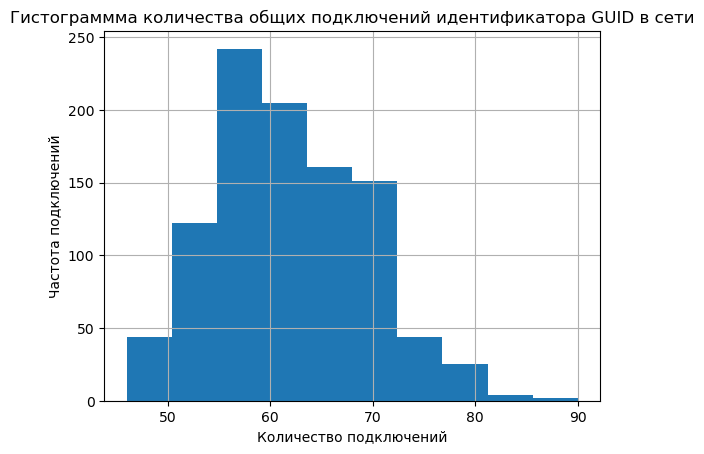

In [9]:
full_data['GUID'].value_counts().hist()
plt.xlabel('Количество подключений')
plt.ylabel('Частота подключений')
plt.title('Гистограммма количества общих подключений идентификатора GUID в сети')
plt.show()

В целом распределение похоже на наормальное с пиком в районе 60 подключений, что вполне логично - данные собраны за 2 месяца, в среднем 60 дней, человек подключается к сети каждый рабочий день

Количество дней в течение которых происходил сбор данных

In [10]:
full_data['Timestamp'].max() - full_data['Timestamp'].min()

Timedelta('60 days 15:59:42')

In [11]:
full_data['Timestamp'].min()

Timestamp('2024-03-01 03:00:00')

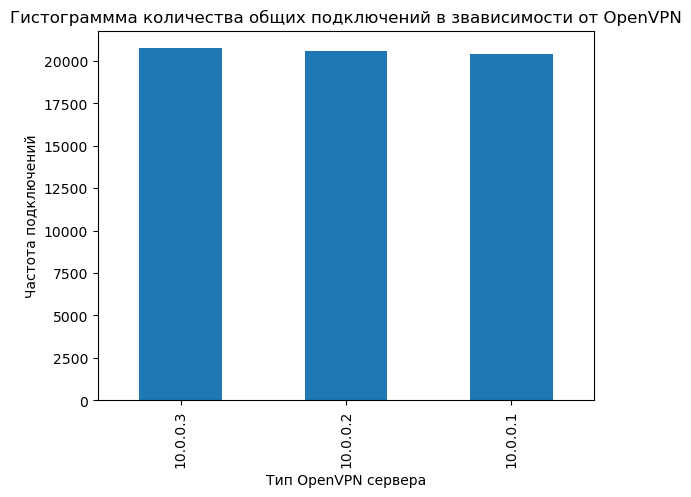

In [12]:
full_data['OpenVPNServer'].value_counts().plot(kind='bar')
plt.xlabel('Тип OpenVPN сервера')
plt.ylabel('Частота подключений')
plt.title('Гистограммма количества общих подключений в звависимости от OpenVPN')
plt.show()

Распрееделение подключений по серверам OpenVPN равномерное

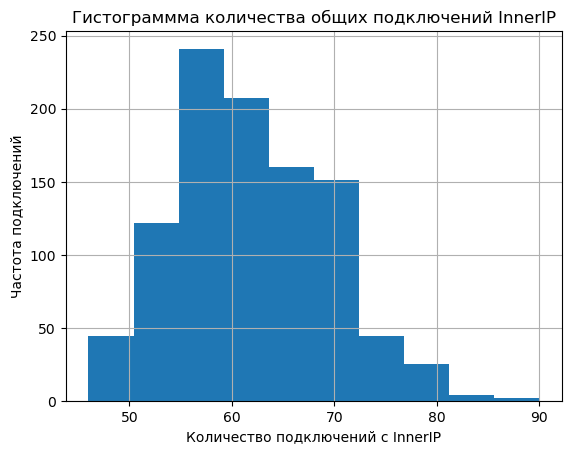

In [13]:
full_data['InnerIP'].value_counts().hist()
plt.xlabel('Количество подключений c InnerIP')
plt.ylabel('Частота подключений')
plt.title('Гистограммма количества общих подключений InnerIP')
plt.show()

По внутренним IP ситуация аналогична ситуации GUID

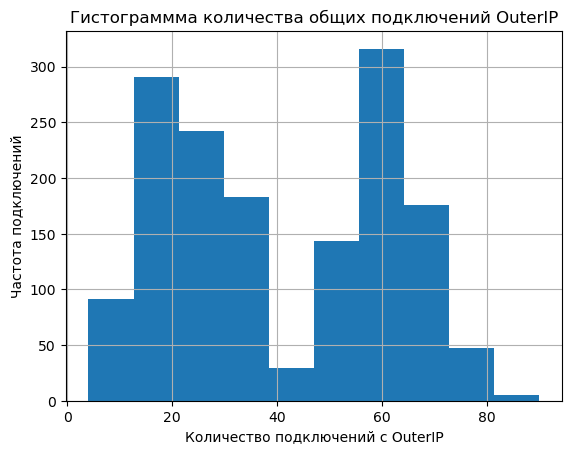

In [14]:
full_data['OuterIP'].value_counts().hist()
plt.xlabel('Количество подключений c OuterIP')
plt.ylabel('Частота подключений')
plt.title('Гистограммма количества общих подключений OuterIP')
plt.show()

Распределение по внешним IP от VPN не такое равномерное или нормальное, наблюдается 2 пика, возможно не все пользуются OuterIP при каждом подключении

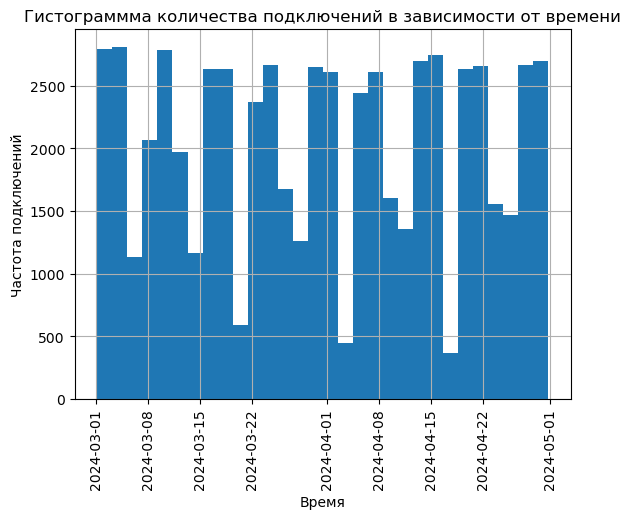

In [15]:
full_data['Timestamp'].hist(bins=30)
plt.xticks(rotation=90)
plt.xlabel('Время')
plt.ylabel('Частота подключений')
plt.title('Гистограммма количества подключений в зависимости от времени')
plt.show()

Далее попробуем посмотреть на сезонность, в целом есть предпложение, что в выходные количество подключений падает, а в будни растет

In [16]:
data_for_season = full_data.set_index('Timestamp')

In [17]:
seasonal_data = data_for_season['GUID'].resample('1D').count()

In [18]:
decomposed = seasonal_decompose(seasonal_data)

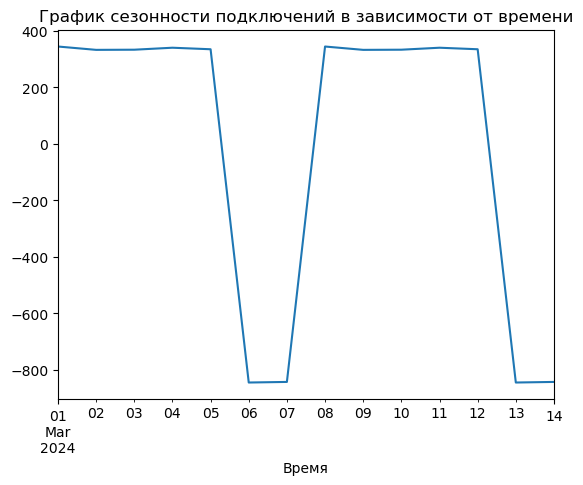

In [19]:
decomposed.seasonal['2024-03-01':'2024-03-14'].plot()
plt.xlabel('Время')
plt.title('График сезонности подключений в зависимости от времени')
plt.show()

В целом гипотеза подтвердилась, количество записей(подключений) зависит от дня недели, 2 дня в среднем количество подключений минимально, в остальные наблюдается плато

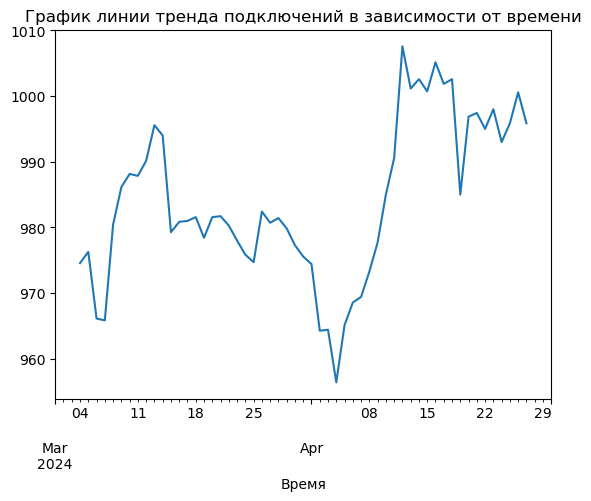

In [20]:
decomposed.trend.plot()
plt.xlabel('Время')
plt.title('График линии тренда подключений в зависимости от времени')
plt.show()

О наличие тренда за 2 месяца ничего сказать нельзя

## Аномальные виды поведения

Далее найдём людей которые подключается к чужим компьютерам, заходят с InnerIP адресов

In [21]:
staff = full_data.merge(full_data,on='InnerIP').query('GUID_x != GUID_y')['GUID_x'].unique()

In [22]:
full_data.query('GUID in @staff')[['LastName','FirstName','MiddleName']].drop_duplicates()

,LastName,FirstName,MiddleName
45,Локотков,Александр,Владимирович
79,Павлов,Юрий,Аркадьевич
156,Власов,Владислав,Анатольевич
341,Андреева,Ирина,Александровна


Далее посмотрим на анамальное поведение второго типа - люди несколько дней не заходили в сеть

In [23]:
full_data.groupby('GUID')['Timestamp'].diff().sort_values(ascending=False).head(10)

57148   6 days 01:52:20
22817   6 days 00:49:24
41570   5 days 23:15:50
7034    5 days 12:11:51
58438   5 days 02:12:28
50143   5 days 01:36:22
58380   5 days 01:04:22
31019   5 days 00:56:12
7397    5 days 00:42:13
41953   5 days 00:41:37
Name: Timestamp, dtype: timedelta64[ns]

In [24]:
leave_index = full_data.groupby('GUID')['Timestamp'].diff().sort_values(ascending=False).head(10).index

In [25]:
full_data[['LastName','FirstName','MiddleName']].loc[leave_index].drop_duplicates()

,LastName,FirstName,MiddleName
57148,Кочнева,Елена,Евгеньевна
22817,Алексеев,Иван,Александрович
41570,Кротов,Денис,Николаевич
7034,Комлев,Евгений,Николаевич
58438,Иванова,Анна,Федоровна
50143,Болдырева,Ольга,Николаевна
58380,Дидяева,Галина,Владимировна
31019,Кургузова,Елена,Гариевна
7397,Петряев,Антон,Маратович
41953,Волкова,Елена,Владимировна


Вот список людей, которые не находились на месте более 5 полных дней

## Выводы

Распределение количества подключений в зависимости от рабочих мест (InnerIP) похоже на нормальное с максимумом в раойне 60 подключений, распредеелние по OuterIP похоже на бимодальное - есть два пика, то есть некоторыми внешними IP пользуются часще, а какими-то реже. В данных наблюдается сезонность, в буднии дни колисество подключений макисмально, в выходные минимально. 

Также среди пользователей наблюдается 2 типа аномального опведения - некоторые пользователи логинятся с чужих устройств, таких человека 4, возможно это админы, также есть несколько человек, которые более 5 дней не появлялись на рабочем месте